In [1]:
import openturns as ot
import math as m
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from openturns.viewer import View

# Random Walk Metropolis Hastings 1D

In [2]:
log_density = ot.SymbolicFunction('x', 'log(2 + sin(x)^2) - (2 + cos(3*x)^3 + sin(2*x)^3) * x')
support = ot.Interval([0.0], [2.0 * m.pi])
proposal = ot.Normal(0.0, 2.0)
initialState = [3.0]
sampler = ot.RandomWalkMetropolisHastings(log_density, support, initialState, proposal)
x = sampler.getSample(10000)

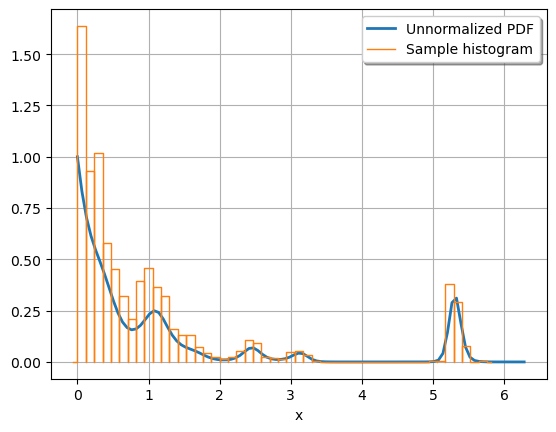

In [3]:
ot.RandomGenerator.SetSeed(1)
f = ot.SymbolicFunction(
    "x", "0.5 * (2 + sin(x)^2) * exp( -( 2 + cos(3*x)^3 + sin(2*x)^3) * x )"
)
lower_bound = 0.0
upper_bound = 2.0 * m.pi
graph = f.draw(lower_bound, upper_bound, 100)
line = graph.getDrawable(0)
line.setLineWidth(2)
graph.setDrawable(line, 0)
graph.setTitle("")
graph.setXTitle("")
graph.setYTitle("")
hist = ot.HistogramFactory().build(x).drawPDF().getDrawable(0)
hist.setLineWidth(1)
hist.setColor("black")
graph.add(hist)
graph.setColors(ot.Drawable.BuildDefaultPalette(2))
graph.setLegends(["Unnormalized PDF", "Sample histogram"])
graph.setLegendPosition("topright")
graph.setXTitle("x")
view = View(graph)
view.save("figures/ChristianRobert_tough_density.pdf")

# Fonction auxiliaire de visualisation

In [4]:
def ComputeMeshGrid2DFunctionValue(
    function, interval, numberOfXCells=100, numberOfYCells=100
):
    """
    Compute the value of the function on a mesh. 
    
    This is handy for contour plots.

    Parameters
    ----------
    function : ot.Function(2, 1)
        The function, which input has dimension 2 and output has dimension 1.
    interval : ot.Interval(2)
        A 2D interval.
    numberOfXCells : int, optional
        The number of cells on the X axis. The default is 100.
    numberOfYCells : int, optional
        The number of cells on the Y axis. The default is 100.

    Raises
    ------
    ValueError
        If the input dimension is not equal to 2 or the output dimension 
        is not equal to 1.

    Returns
    -------
    xArray : np.array(numberOfYCells, numberOfXCells)
        The input X array.
    yArray : np.array(numberOfYCells, numberOfXCells)
        The input Y array.
    zArray : np.array(numberOfYCells, numberOfXCells)
        The output array.

    """
    if interval.getDimension() != 2:
        raise ValueError(
            "Dimension of interval is equal "
            "to %d, which is not equal to 2" % (interval.getDimension())
        )
    if function.getInputDimension() != 2:
        raise ValueError(
            "Input dimension of function is equal "
            "to %d, which is not equal to 2" % (function.getInputDimension())
        )
    if function.getOutputDimension() != 1:
        raise ValueError(
            "Output dimension of function is equal "
            "to %d, which is not equal to 1" % (function.getOutputDimension())
        )
    # Create the input mesh
    lowerBound = interval.getLowerBound()
    upperBound = interval.getUpperBound()
    xList = np.linspace(lowerBound[0], upperBound[0], numberOfXCells)
    yList = np.linspace(lowerBound[1], upperBound[1], numberOfYCells)
    xArray, yArray = np.meshgrid(xList, yList)
    # Convert to Sample
    xArrayFlat = xArray.flatten()
    yArrayFlat = yArray.flatten()
    size = numberOfXCells * numberOfYCells
    inputSample = ot.Sample(size, 2)
    inputSample[:, 0] = ot.Sample.BuildFromPoint(xArrayFlat)
    inputSample[:, 1] = ot.Sample.BuildFromPoint(yArrayFlat)
    # Evaluate the function
    zArray = function(inputSample)
    zArray = np.array(zArray)
    zArray = zArray.transpose()
    zArray = np.reshape(zArray, (numberOfYCells, numberOfXCells))
    return xArray, yArray, zArray

# Random Walk Metropolis Hastings 2D

In [5]:
logdensity = ot.SymbolicFunction(
    ["x", "y"], ["log(exp(-0.25 * (x-3)^2 + y^2) + exp(-(x-5)^2 - 5 * (y-0.2)^2))"]
)
support = ot.Interval([0.0, 0.0], [2.0 * m.pi, 1.0])
proposal = ot.Normal([0.0] * 2, [1.0, 0.2]) # mu
initialState = [3.0 , 0.8]
sampler = ot .RandomWalkMetropolisHastings(logdensity, support, initialState , proposal)
x = sampler . getSample (50000)

In [6]:
f = ot.SymbolicFunction(
    ["x", "y"], ["exp(-0.25 * (x-3)^2 + y^2) + exp(-(x-5)^2 - 5 * (y-0.2)^2)"]
)

xArray, yArray, zArray = ComputeMeshGrid2DFunctionValue(
    f, support, numberOfXCells=100, numberOfYCells=100
)

<Figure size 640x480 with 0 Axes>

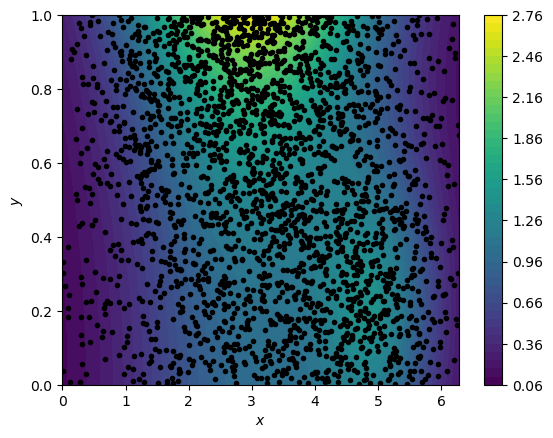

In [7]:
# Plot with customized levels
_ = plt.figure()
fig, ax = plt.subplots(1, 1)
#cmap = mpl.cm.viridis_r
cp = ax.contourf(xArray, yArray, zArray, levels=50, cmap=mpl.cm.viridis)
_ = fig.colorbar(cp)
_ = ax.set_title("")
_ = ax.set_xlabel(r"$x$")
_ = ax.set_ylabel(r"$y$")
step = 20
pts = ax.scatter(x[0::step, 0], x[0::step,1], marker='.', color='black')
fig.savefig("figures/2d.pdf")

# Cas 2D prior + vraisemblance

In [8]:
conditional = ot.WeibullMin()

In [9]:
conditional.getParameterDescription()

[beta,alpha,gamma]

In [10]:
Tobs = [[4380], [1791], [1611], [1291]]#, [6132], [5694], [5296], [4818], [4818], [4380]])

In [11]:
alpha_min, alpha_max = 0.5, 3.8
a_beta, b_beta = 2, 2e-4

priorMarginals = [ot.Gamma(a_beta, b_beta), ot.Uniform(alpha_min, alpha_max)]  # prior marginals
# priorMarginals.append(ot.Gamma(a_beta, b_beta))  # Gamma prior for beta
# priorMarginals.append(ot.Uniform(alpha_min, alpha_max))  # uniform prior for alpha
prior = ot.ComposedDistribution(priorMarginals)#, priorCopula)
prior.setDescription(["beta", "alpha"])

In [12]:
initialState = [a_beta / b_beta, 0.5 * (alpha_max - alpha_min)]

In [13]:
proposal = ot.Normal([0.0] * 2, [0.1 * np.sqrt(a_beta / b_beta ** 2), 0.1 * (alpha_max - alpha_min)])

In [14]:
sampler = ot.RandomWalkMetropolisHastings(prior, initialState, proposal)
linkFunction = ot.SymbolicFunction(["beta", "alpha"], ["beta", "alpha", "0.0"])
sampler.setLikelihood(conditional, Tobs, linkFunction)
sampleSize = 100000
sample = sampler.getSample(sampleSize)
# compute acceptance rate
print("Acceptance rate: %s" % (sampler.getAcceptanceRate()))

Acceptance rate: 0.66818


In [15]:
def post(X):
    return [m.exp(sampler.computeLogPosterior(X))]

posterior = ot.PythonFunction(2, 1, post)

/home/C39575/miniforge3/envs/graphite/lib/python3.10/site-packages/openturns/viewer.py:517: UserWarning: No contour levels were found within the data range.
  contourset = self._ax[0].contour(X, Y, Z, **contour_kw)


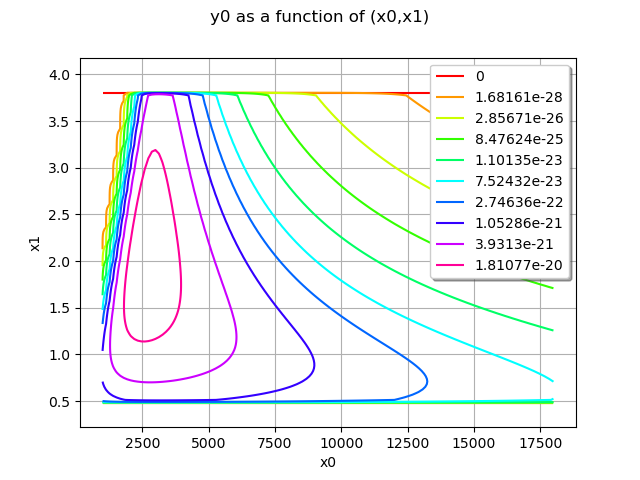

In [16]:
posterior.draw([1000, 0.4], [18000, 4.0])

In [17]:
step = 200
thinned_sample = sample[0::step]

xArray, yArray, zArray = ComputeMeshGrid2DFunctionValue(
    posterior, ot.Interval(sample.getMin(), sample.getMax()), numberOfXCells=50, numberOfYCells=50
)

<Figure size 640x480 with 0 Axes>

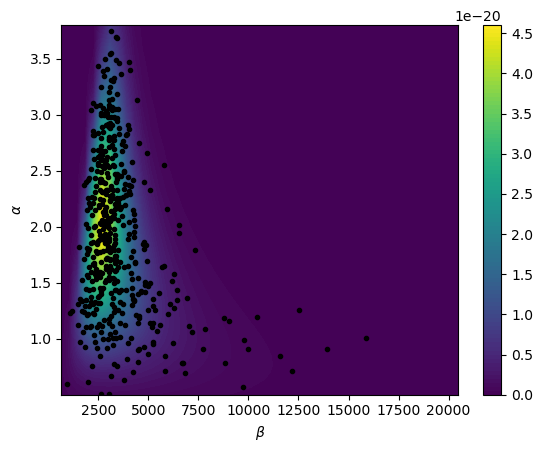

In [18]:
# Plot with customized levels
_ = plt.figure()
fig, ax = plt.subplots(1, 1)
#cmap = mpl.cm.viridis_r
cp = ax.contourf(xArray, yArray, zArray, levels=100, cmap=mpl.cm.viridis)
_ = fig.colorbar(cp)
_ = ax.set_title("")
_ = ax.set_xlabel(r"$\beta$")
_ = ax.set_ylabel(r"$\alpha$")
pts = ax.scatter(thinned_sample[:, 0], thinned_sample[:,1], marker='.', color='black')
fig.savefig("figures/fiabilite.pdf")

# Flood model : Single component Metropolis Hastings

In [19]:
def flooding(X):
    L = 5.0e3
    B = 300.0
    Q, K_s, Z_v, Z_m = X
    alpha = (Z_m - Z_v) / L
    if alpha < 0.0 or K_s <= 0.0:
        H = np.inf
    else:
        H = (Q / (K_s * B * np.sqrt(alpha))) ** (3.0 / 5.0)
    return [H, 0.5]

funcFlooding = ot.PythonFunction(4, 2, flooding)

# Q (input #0) is not calibrated
linkFunction = ot.ParametricFunction(funcFlooding, [0], [100])


In [20]:
Qobs = [[2097], [1448], [1516], [2173], [387], [3016], [ 651], [ 541]]
Hobs = [[3.4], [2.5], [2.7], [3.5], [1.0], [4.2], [1.6], [1.6]]


In [21]:
parameterPriorMean = [20.0, 49.0, 51.0]
parameterPriorSigma = [5.0, 1.0, 1.0]
prior = ot.Normal(parameterPriorMean, parameterPriorSigma)
conditional = ot.Normal()
initialState = parameterPriorMean


In [22]:
mh_coll = [
    ot.RandomWalkMetropolisHastings(prior, parameterPriorMean, ot.Uniform(-5.0, 5.0), [0]),
    ot.RandomWalkMetropolisHastings(prior, parameterPriorMean, ot.Uniform(-1.0, 1.0), [1]),
    ot.RandomWalkMetropolisHastings(prior, parameterPriorMean, ot.Uniform(-1.0, 1.0), [2]),
]

for mh in mh_coll:
    mh.setLikelihood(conditional, Hobs, linkFunction, Qobs)
sampler = ot.Gibbs(mh_coll)

Ks_sampler = mh_coll[0]

In [23]:
sample = sampler.getSample(10000)
sample.setDescription(["$K_s$", "$Z_v$", "$Z_m$"])

In [24]:
def post(X):
    return [m.exp(Ks_sampler.computeLogPosterior(X))]

posterior = ot.PythonFunction(3, 1, post)

<Figure size 1200x1200 with 0 Axes>

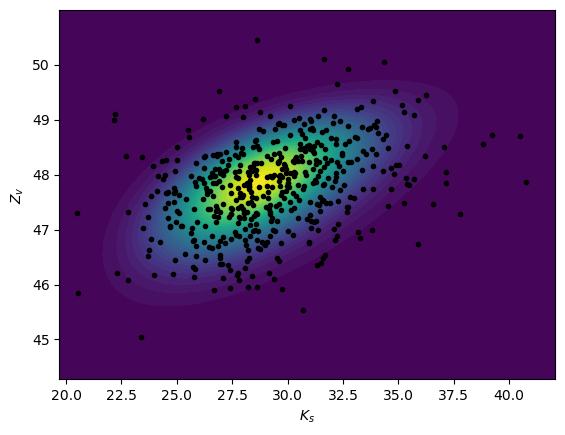

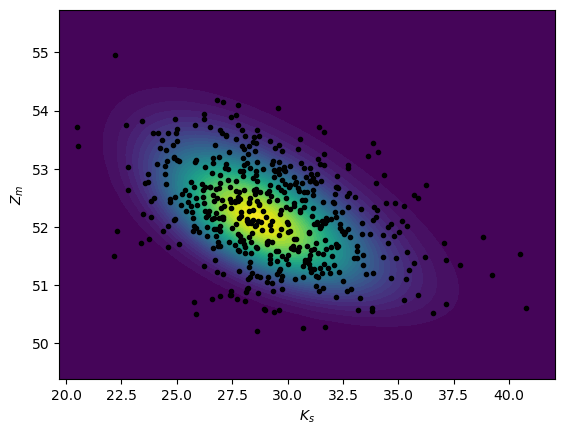

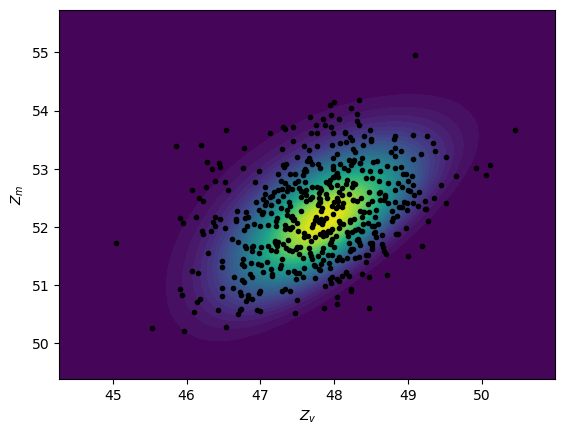

In [25]:
step = 20
thinned_sample = sample[0::step]

fig = plt.figure(figsize=(12, 12))
lowerBound = sample.getMin()
upperBound = sample.getMax()

# Definition of number of meshes in x and y axes for the 2D cross cut plots
nX = 50
nY = 50
for i in range(3):
    for j in range(i):
        crossCutIndices = []
        crossCutReferencePoint = []
        for k in range(3):
            if k != i and k != j:
                crossCutIndices.append(k)
                # Definition of the reference point
                crossCutReferencePoint.append(sample.computeMean()[k])
        # Definition of 2D cross cut function
        crossCutFunction = ot.ParametricFunction(
            posterior, crossCutIndices, crossCutReferencePoint
        )
        crossCutLowerBound = [lowerBound[j], lowerBound[i]]
        crossCutUpperBound = [upperBound[j], upperBound[i]]
        # Definition of the mesh
        inputData = ot.Box([nX, nY]).generate()
        inputData *= ot.Point(crossCutUpperBound) - ot.Point(crossCutLowerBound)
        inputData += ot.Point(crossCutLowerBound)
        meshX = np.array(inputData)[:, 0].reshape(nX + 2, nY + 2)
        meshY = np.array(inputData)[:, 1].reshape(nX + 2, nY + 2)
        data = crossCutFunction(inputData)
        meshZ = np.array(data).reshape(nX + 2, nY + 2)
        levels = [(150 + 3 * i) for i in range(101)]

        # Creation of the contour
        index = 1 + i * 3 + j

        fig, ax = plt.subplots(1, 1)
        # ax.pcolormesh(
        #     meshX, meshY, meshZ, cmap="viridis", vmin=0.0, vmax=5.6e-5, shading="auto"
        # )
        ax.contourf(meshX, meshY, meshZ, levels=50, cmap=mpl.cm.viridis)
        #ax.set_xticks([])
        #ax.set_yticks([])
        ax.scatter(thinned_sample[:, j], thinned_sample[:, i], marker='.', color='black')

        # Creation of axes title
        ax.set_ylabel(sample.getDescription()[i])
        ax.set_xlabel(sample.getDescription()[j])
        
        fig.savefig("figures/crue_gibbs_scmh_{}_{}.pdf".format(sample.getDescription()[i][1:-1], sample.getDescription()[j][1:-1]))

# Blockwise Gibbs

In [26]:
mh_coll = [
    ot.RandomWalkMetropolisHastings(prior, parameterPriorMean, ot.Uniform(-5.0, 5.0), [0]),
    ot.RandomWalkMetropolisHastings(prior, parameterPriorMean, 
                                        ot.ComposedDistribution([ot.Uniform(-1.0, 1.0)] * 2), [1, 2]),
]

for mh in mh_coll:
    mh.setLikelihood(conditional, Hobs, linkFunction, Qobs)
sampler = ot.Gibbs(mh_coll)

In [27]:
sample = sampler.getSample(10000)
sample.setDescription(["$K_s$", "$Z_v$", "$Z_m$"])

In [28]:
sample

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=10000 dimension=3 description=[$K_s$,$Z_v$,$Z_m$] data=[[20,49,51],[20,49,51],[24.716,48.3386,51.6236],...,[29.5301,47.1051,52.4319],[24.9874,48.0243,53.0148],[26.4315,48.0243,53.0148]]

<Figure size 1200x1200 with 0 Axes>

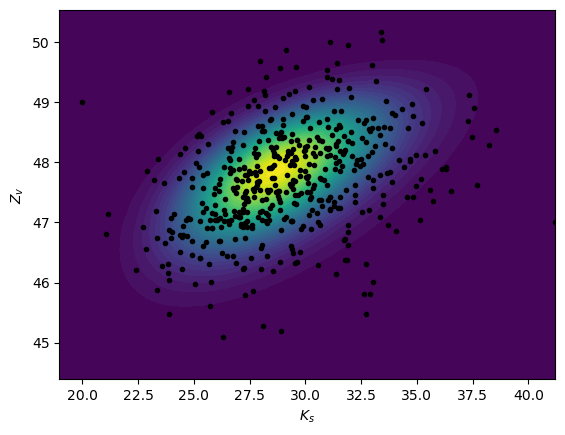

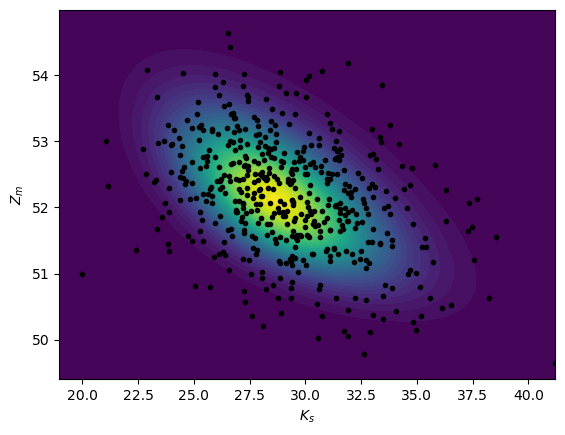

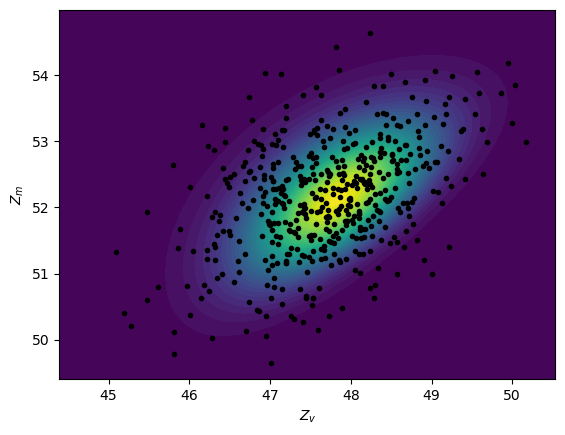

In [29]:
step = 20
thinned_sample = sample[0::step]

fig = plt.figure(figsize=(12, 12))
lowerBound = sample.getMin()
upperBound = sample.getMax()

# Definition of number of meshes in x and y axes for the 2D cross cut plots
nX = 50
nY = 50
for i in range(3):
    for j in range(i):
        crossCutIndices = []
        crossCutReferencePoint = []
        for k in range(3):
            if k != i and k != j:
                crossCutIndices.append(k)
                # Definition of the reference point
                crossCutReferencePoint.append(sample.computeMean()[k])
        # Definition of 2D cross cut function
        crossCutFunction = ot.ParametricFunction(
            posterior, crossCutIndices, crossCutReferencePoint
        )
        crossCutLowerBound = [lowerBound[j], lowerBound[i]]
        crossCutUpperBound = [upperBound[j], upperBound[i]]
        # Definition of the mesh
        inputData = ot.Box([nX, nY]).generate()
        inputData *= ot.Point(crossCutUpperBound) - ot.Point(crossCutLowerBound)
        inputData += ot.Point(crossCutLowerBound)
        meshX = np.array(inputData)[:, 0].reshape(nX + 2, nY + 2)
        meshY = np.array(inputData)[:, 1].reshape(nX + 2, nY + 2)
        data = crossCutFunction(inputData)
        meshZ = np.array(data).reshape(nX + 2, nY + 2)
        levels = [(150 + 3 * i) for i in range(101)]

        # Creation of the contour
        index = 1 + i * 3 + j

        fig, ax = plt.subplots(1, 1)
        # ax.pcolormesh(
        #     meshX, meshY, meshZ, cmap="viridis", vmin=0.0, vmax=5.6e-5, shading="auto"
        # )
        ax.contourf(meshX, meshY, meshZ, levels=50, cmap=mpl.cm.viridis)
        #ax.set_xticks([])
        #ax.set_yticks([])
        ax.scatter(thinned_sample[:, j], thinned_sample[:, i], marker='.', color='black')

        # Creation of axes title
        ax.set_ylabel(sample.getDescription()[i])
        ax.set_xlabel(sample.getDescription()[j])
        
        fig.savefig("figures/crue_gibbs_blocs_{}_{}.pdf".format(sample.getDescription()[i][1:-1], sample.getDescription()[j][1:-1]))

# Independent Metropolis Hastings

In [30]:
log_density = ot.SymbolicFunction(
    "x", "log(2 + sin(x)^2) - (2 + cos(3*x)^3 + sin(2*x)^3) * x"
)

exp = ot.Exponential(1.0)
unif = ot.Normal(5.3, 0.4)
instrumentalDistribution = ot.Mixture([exp, unif], [0.9, 0.1])


initialState = [3.0]  # not important in this case
support = ot.Interval([lower_bound], [upper_bound])
independentMH = ot.IndependentMetropolisHastings(
    log_density, support, initialState, instrumentalDistribution
)
x = independentMH.getSample(10000)

In [31]:
ot.RandomGenerator.SetSeed(1)
f = ot.SymbolicFunction(
    "x", "0.5 * (2 + sin(x)^2) * exp( -( 2 + cos(3*x)^3 + sin(2*x)^3) * x )"
)
lower_bound = 0.0
upper_bound = 2.0 * m.pi

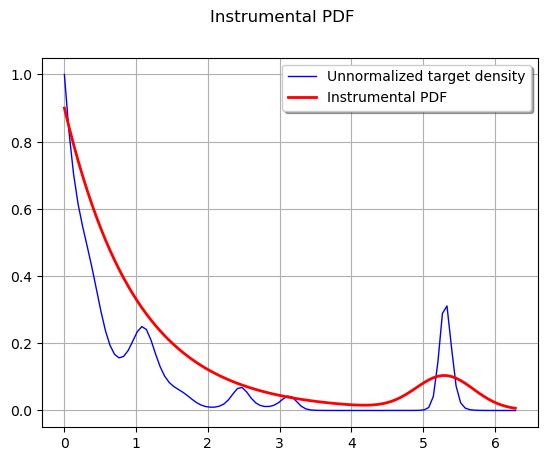

In [32]:
graph = f.draw(lower_bound, upper_bound, 100)
graph.setTitle("Instrumental PDF")
graph.setXTitle("")
graph.setYTitle("")
graph.add(instrumentalDistribution.drawPDF(lower_bound, upper_bound, 100))
graph.setLegendPosition("topright")
graph.setLegends(["Unnormalized target density", "Instrumental PDF"])
view = View(graph)
view.save("figures/instrumental.pdf")

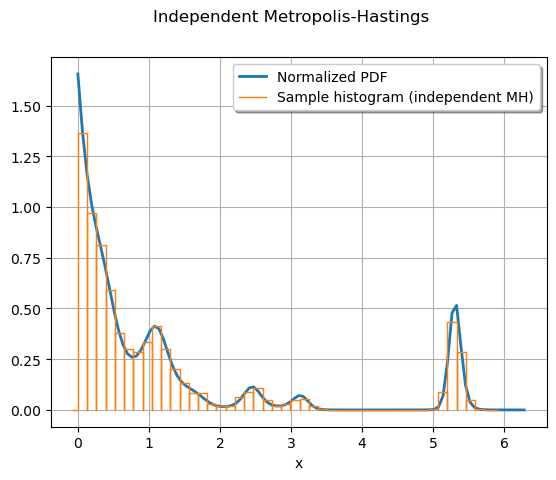

In [33]:
ot.RandomGenerator.SetSeed(1)
f = ot.SymbolicFunction(
    "x", "0.82817655 * (2 + sin(x)^2) * exp( -( 2 + cos(3*x)^3 + sin(2*x)^3) * x )"
)
lower_bound = 0.0
upper_bound = 2.0 * m.pi
graph = f.draw(lower_bound, upper_bound, 100)
line = graph.getDrawable(0)
line.setLineWidth(2)
graph.setDrawable(line, 0)
graph.setTitle("Independent Metropolis-Hastings")
graph.setXTitle("")
graph.setYTitle("")
hist = ot.HistogramFactory().build(x).drawPDF().getDrawable(0)
hist.setLineWidth(1)
hist.setColor("black")
graph.add(hist)
graph.setColors(ot.Drawable.BuildDefaultPalette(2))
graph.setLegends(["Normalized PDF", "Sample histogram (independent MH)"])
graph.setLegendPosition("topright")
graph.setXTitle("x")
view = View(graph)
view.save("figures/independentMH.pdf")

In [34]:
proposal = ot.Normal(0.0, 2.0)
rwMH = ot.RandomWalkMetropolisHastings(log_density, support, initialState, proposal)
y = rwMH.getSample(10000)

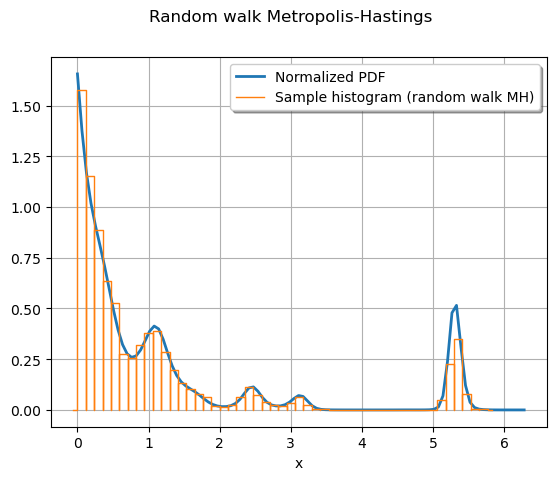

In [35]:
ot.RandomGenerator.SetSeed(1)
f = ot.SymbolicFunction(
    "x", "0.82817655 * (2 + sin(x)^2) * exp( -( 2 + cos(3*x)^3 + sin(2*x)^3) * x )"
)
lower_bound = 0.0
upper_bound = 2.0 * m.pi
graph = f.draw(lower_bound, upper_bound, 100)
line = graph.getDrawable(0)
line.setLineWidth(2)
graph.setDrawable(line, 0)
graph.setTitle("Random walk Metropolis-Hastings")
graph.setXTitle("")
graph.setYTitle("")
hist = ot.HistogramFactory().build(y).drawPDF().getDrawable(0)
hist.setLineWidth(1)
graph.add(hist)
# hist = ot.HistogramFactory().build(x).drawPDF().getDrawable(0)
# hist.setLineWidth(1)
# graph.add(hist)
graph.setColors(ot.Drawable.BuildDefaultPalette(2))
graph.setLegends(["Normalized PDF", "Sample histogram (random walk MH)"])#, "Sample histogram (independent MH)"])
graph.setLegendPosition("topright")
graph.setXTitle("x")
view = View(graph)
view.save("figures/randomwalkMH.pdf")

# User Defined Metropolis Hastings

In [36]:
proposal = ot.Normal()
h = 0.5
std_deviation = m.sqrt(h)
initialState = [2.5]

In [37]:
from openturns.experimental import UserDefinedMetropolisHastings
def python_link(x):
    derivative_log_density = log_density.getGradient().gradient(x)[0, 0]
    mean = x[0] + h / 2 * derivative_log_density
    return [mean, std_deviation]

link = ot.PythonFunction(1, 2, python_link)
mala = UserDefinedMetropolisHastings(log_density, support, initialState, proposal, link)
z = mala.getSample(10000)

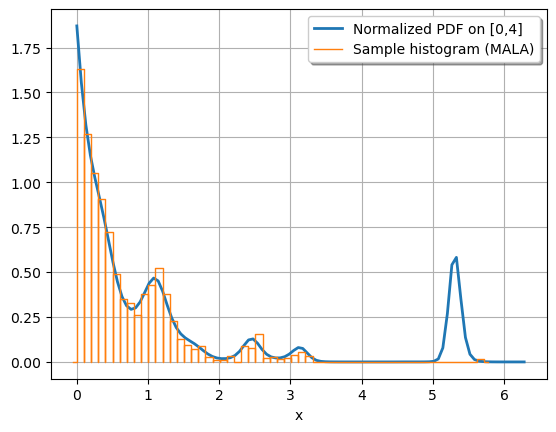

In [38]:
ot.RandomGenerator.SetSeed(1)
f = ot.SymbolicFunction(
    "x", "0.935298 * (2 + sin(x)^2) * exp( -( 2 + cos(3*x)^3 + sin(2*x)^3) * x )"
)
lower_bound = 0.0
upper_bound = 2.0 * m.pi
graph = f.draw(lower_bound, upper_bound, 100)
line = graph.getDrawable(0)
line.setLineWidth(2)
graph.setDrawable(line, 0)
#graph.setTitle("Metropolis adjusted Langevin algorithm (MALA)")
graph.setTitle("")
graph.setXTitle("")
graph.setYTitle("")
hist = ot.HistogramFactory().build(z).drawPDF().getDrawable(0)
hist.setLineWidth(1)
graph.add(hist)
# hist = ot.HistogramFactory().build(x).drawPDF().getDrawable(0)
# hist.setLineWidth(1)
# graph.add(hist)
graph.setColors(ot.Drawable.BuildDefaultPalette(2))
graph.setLegends(["Normalized PDF on [0,4]", "Sample histogram (MALA)"])
graph.setLegendPosition("topright")
graph.setXTitle("x")
view = View(graph)
view.save("figures/MALA.pdf")

# Random vector Metropolis-Hastings

In [39]:
ot.RandomGenerator.SetSeed(1)

n = 10
p=2


In [40]:
X = ot.Sample([[1.0]] * n)
Xcol = [[9.6], [9.5], [-16.6], [3.9], [-10.9], [7.8], [10.9], [-6.5], [15.8], [6.1]]
X.stack(Xcol)
X

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=10 dimension=2 data=[[1,9.6],[1,9.5],[1,-16.6],[1,3.9],[1,-10.9],[1,7.8],[1,10.9],[1,-6.5],[1,15.8],[1,6.1]]

In [41]:
Q = np.array([[1.4], [1.1], [4.1], [1.0], [2.9], [3.3], [1.0], [2.1], [2.9], [1.6]])
Q

array([[1.4],
       [1.1],
       [4.1],
       [1. ],
       [2.9],
       [3.3],
       [1. ],
       [2.1],
       [2.9],
       [1.6]])

In [42]:
Y_sim = [4.9, 8.0, -16.8, 6.1, -7.1, 2.3, 10.9, -3.0, 20.2, 3.7]

In [43]:
Y_sample = [[4.9], [8.0], [-16.8], [6.1], [-7.1], [2.3], [10.9], [-3.0], [20.2], [3.7]]

In [44]:
def py_link_function_y(x):
    """
    link function for Y conditional density

    Input
        x: vector with length (p + 1 + n), containing the current state of (theta, tau, Y)

    Output
        params: vector with length 4*n, corresponding to mean, std, a and b, for each component of Y

    Notes
        a and b represent the upper and lower bounds for the truncated normals
    """
    theta = [x[i] for i in range(p)]
    tau = x[p]
    # compute conditional mean and standard deviates
    mean = np.dot(X, theta)
    std = np.sqrt(1.0 / tau + 1.0 / Q)
    # inject values in blueprint
    params = np.zeros(2 * n)
    params[::2] = mean
    params[1::2] = std.ravel()
    return params

link_function_y = ot.PythonFunction(1+p, 2 * n, py_link_function_y)


In [45]:
RV_theta = ot.RandomVector(ot.Normal(p))

In [46]:


def py_link_function_theta(x):
    tau = x[p]
    #Y = [x[i] for i in range(p + 1, len(x))]
    # conditional mean and variance
    # for diagonal Q
    Itilde_inv = 1.0 / (1.0 + tau / Q)
    Xtilde = Itilde_inv * X
    Sigma_n = np.linalg.inv(np.dot(Xtilde.T, X)) / tau
    mu_n = np.dot(Xtilde.T, Y_sim)
    mu_n = tau * np.dot(Sigma_n, mu_n)
    return ot.Normal(mu_n, ot.CovarianceMatrix(Sigma_n)).getParameter()


In [47]:
initialState = [1.0] * (1+p)

In [48]:
mi_theta = [i for i in range(p)]
link_function_theta = ot.PythonFunction(1 + p, p + (p + 1) * p // 2, py_link_function_theta)
rvmh_theta = ot.RandomVectorMetropolisHastings(
    RV_theta, initialState[0:3], mi_theta, link_function_theta
)

In [49]:
proposal_tau = ot.Normal(0.0, 1e-1)
prior_tau = ot.SymbolicFunction(["theta1", "theta2", "tau"], ["-log(tau)"])
rwmh_tau = ot.RandomWalkMetropolisHastings(prior_tau, ot.Interval([-np.inf, -np.inf, 0.0], [np.inf] * 3), initialState, proposal_tau, [p])
rwmh_tau.setLikelihood(ot.ComposedDistribution([ot.Normal()] * len(Y_sim)), [Y_sim], link_function_y)

In [50]:
gibbs = ot.Gibbs([rwmh_tau, rvmh_theta])


In [51]:
sample = gibbs.getSample(10000)

In [52]:
sample.setDescription([r"$\theta_1$", r"$\theta_2$", r"$\tau$"])

In [53]:
def post(X):
    tau = X[-1]
    return [m.exp(rwmh_tau.computeLogLikelihood(X) - m.log(tau))]

posterior = ot.PythonFunction(1 + p, 1, post)

<Figure size 1200x1200 with 0 Axes>

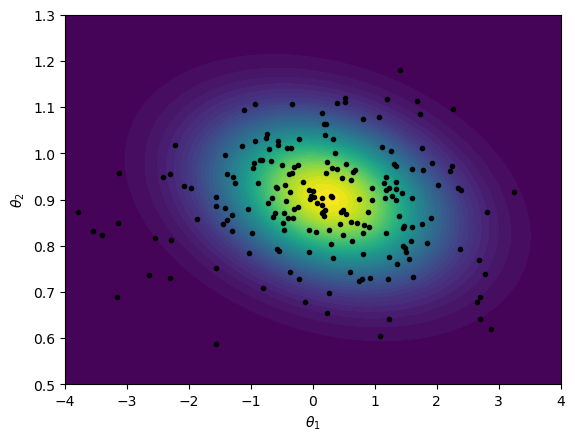

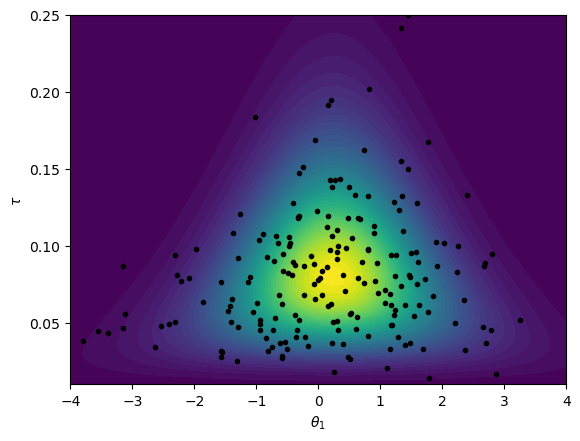

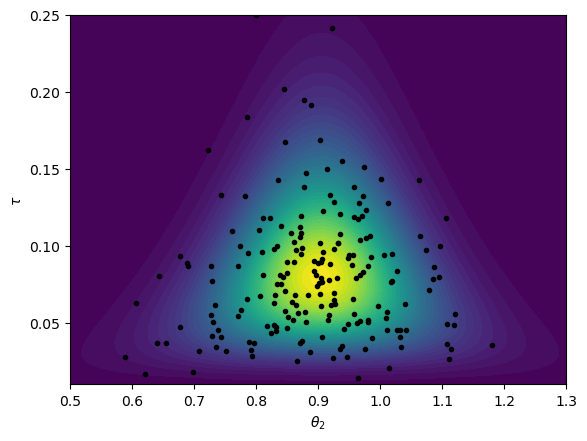

In [54]:
step = 50
thinned_sample = sample[step::step]
lowerBound = [-4, 0.5, 0.01]
upperBound = [4, 1.3, 0.25]
domain = ot.Interval(lowerBound, upperBound)
displayed_sample = ot.Sample(0, thinned_sample.getDimension())
for pt in thinned_sample:
    if domain.contains(pt):
        displayed_sample.add(pt)
fig = plt.figure(figsize=(12, 12))
# lowerBound = np.array(thinned_sample.getMin()) - 0.01
# upperBound = np.array(thinned_sample.getMax()) + 0.1

# Definition of number of meshes in x and y axes for the 2D cross cut plots
nX = 50
nY = 50
for i in range(3):
    for j in range(i):
        crossCutIndices = []
        crossCutReferencePoint = []
        for k in range(3):
            if k != i and k != j:
                crossCutIndices.append(k)
                # Definition of the reference point
                crossCutReferencePoint.append(sample.computeMean()[k])
        # Definition of 2D cross cut function
        crossCutFunction = ot.ParametricFunction(
            posterior, crossCutIndices, crossCutReferencePoint
        )
        crossCutLowerBound = [lowerBound[j], lowerBound[i]]
        crossCutUpperBound = [upperBound[j], upperBound[i]]
        # Definition of the mesh
        inputData = ot.Box([nX, nY]).generate()
        inputData *= ot.Point(crossCutUpperBound) - ot.Point(crossCutLowerBound)
        inputData += ot.Point(crossCutLowerBound)
        meshX = np.array(inputData)[:, 0].reshape(nX + 2, nY + 2)
        meshY = np.array(inputData)[:, 1].reshape(nX + 2, nY + 2)
        data = crossCutFunction(inputData)
        meshZ = np.array(data).reshape(nX + 2, nY + 2)
        levels = [(150 + 3 * i) for i in range(101)]

        # Creation of the contour
        index = 1 + i * 3 + j

        fig, ax = plt.subplots(1, 1)
        # ax.pcolormesh(
        #     meshX, meshY, meshZ, cmap="viridis", vmin=0.0, vmax=5.6e-5, shading="auto"
        # )
        ax.contourf(meshX, meshY, meshZ, levels=50, cmap=mpl.cm.viridis)
        #ax.set_xticks([])
        #ax.set_yticks([])
        ax.scatter(displayed_sample[:, j], displayed_sample[:, i], marker='.', color='black')

        # Creation of axes title
        ax.set_ylabel(sample.getDescription()[i])
        ax.set_xlabel(sample.getDescription()[j])
        
        fig.savefig("figures/rvmh_blocs_{}_{}.pdf".format(sample.getDescription()[i][2:-1], sample.getDescription()[j][2:-1]))